# Repeat Copy Task
### Differentiable Neural Computer (DNC) using a RNN Controller

<a href="https://goo.gl/6eiJFc"><img src="../static/dnc_schema.png" alt="DNC schema" style="width: 700px;"/></a>

**Sam Greydanus $\cdot$ February 2017 $\cdot$ MIT License.**

Represents the state of the art in differentiable memory. Inspired by this [Nature paper](https://goo.gl/6eiJFc). Some ideas taken from [this Gihub repo](https://github.com/Mostafa-Samir/DNC-tensorflow)

## Brain analogy

 However, there are interesting parallels between the memory mechanisms of a DNC and the functional capabilities of the mammalian hippocampus. DNC memory modification is fast and can be one-shot, resembling the associative long-term potentiation of hippocampal CA3 and CA1 synapses. The hippocampal dentate gyrus, a region known to support neurogenesis, has been proposed to increase representational sparsity, thereby enhancing memory capacity: usage- based memory allocation and sparse weightings may provide similar facilities in our model. Human 'free recall' experiments demonstrate the increased probability of item recall in the same order as first presented—a hippocampus-dependent phenomenon accounted for by the temporal context model, bearing some similarity to the formation of temporal links.

In [1]:
import tensorflow as tf
import numpy as np
import sys
sys.path.insert(0, '../dnc')

from dnc import DNC
from rnn_controller import RNNController

import matplotlib.pyplot as plt
%matplotlib inline

### Hyperparameters

In [2]:
xydim = 6
tf.app.flags.DEFINE_integer("xlen", xydim, "Input dimension")
tf.app.flags.DEFINE_integer("ylen", xydim, "output dimension")
tf.app.flags.DEFINE_integer("length", 5, "Sequence length")
tf.app.flags.DEFINE_integer("batch_size", 3, "Size of batch in minibatch gradient descent")

tf.app.flags.DEFINE_integer("R", 1, "Number of DNC read heads")
tf.app.flags.DEFINE_integer("W", 10, "Word length for DNC memory")
tf.app.flags.DEFINE_integer("N", 7, "Number of words the DNC memory can store")

tf.app.flags.DEFINE_integer("print_every", 100, "Print training info after this number of train steps")
tf.app.flags.DEFINE_integer("iterations", 30000, "Number of training iterations")
tf.app.flags.DEFINE_float("lr", 1e-4, "Learning rate (alpha) for the model")
tf.app.flags.DEFINE_float("momentum", .9, "RMSProp momentum")
tf.app.flags.DEFINE_integer("save_every", 1000, "Save model after this number of train steps")
tf.app.flags.DEFINE_string("save_path", "rnn_models/model.ckpt", "Where to save checkpoints")
FLAGS = tf.app.flags.FLAGS

### Data functions

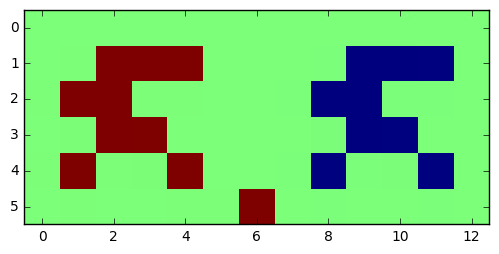

In [3]:
def get_sequence(length, dim):
    X = np.concatenate((np.random.randint(2, size=(length,dim)), np.zeros((length + 3,dim))))
    X = np.vstack(X) ; X[:,dim-1] = 0
    
    X = np.concatenate((X[-1:,:],X[:-1,:]))
    y = np.concatenate((X[-(length + 2):,:],X[:-(length + 2),:]))
    markers = range(length+1, X.shape[0], 2*length+3)
    X[markers,dim-1] = 1
    return X, y
        
def next_batch(batch_size, length, dim):
    X_batch = []
    y_batch = []
    for _ in range(batch_size):
        X, y = get_sequence(length, dim)
        X_batch.append(X) ; y_batch.append(y)
    return [X_batch, y_batch]

batch = next_batch(1, FLAGS.length, FLAGS.xlen)
plt.imshow(batch[0][0].T - batch[1][0].T, interpolation='none')
plt.show()

### Helper functions

In [4]:
def binary_cross_entropy(y, y_hat):
    return tf.reduce_mean(-y*tf.log(y_hat) - (1-y)*tf.log(1-y_hat))

def llprint(message):
    sys.stdout.write(message)
    sys.stdout.flush()

In [5]:
def free_recall_loss(y, y_hat, tsteps):    
    # sorry this dimension stuff is uuuuugly but we have to because it's batched
    y = tf.expand_dims(y, [1])
    y_hat = tf.expand_dims(y_hat, [1])
    
    y_hat = tf.tile(y_hat,[1,tsteps,1,1])
    y_hat = tf.transpose(y_hat, [0,2,1,3])
    
    y_minus = -y*tf.log(y_hat) - (1-y)*tf.log(1-y_hat) # binary cross entropy loss
    y_minus = tf.reduce_sum(y_minus, axis=-1)
    y_minus = tf.reduce_min(y_minus, axis=1)
    
    return tf.reduce_sum(y_minus) / (FLAGS.batch_size*FLAGS.length)

In [6]:
# test free recall loss
X, real_y = next_batch(FLAGS.batch_size, FLAGS.length, FLAGS.xlen)
real_y = np.stack(real_y)[:,-FLAGS.length:,:]

pred_y = [y_i[np.random.permutation(y_i.shape[0]),:] for y_i in real_y]
pred_y = np.stack(pred_y)
# pred_y[:,-2:,-1] = 4

tf_real_y = tf.placeholder(tf.float32, [FLAGS.batch_size, None, FLAGS.ylen], name='real_y')
tf_pred_y = tf.placeholder(tf.float32, [FLAGS.batch_size, None, FLAGS.ylen], name='pred_y')
sess = tf.InteractiveSession()


# clip predictions to range (0,1) to avoid infinite losses
_tf_pred_y = tf.clip_by_value(tf_pred_y, 1e-6, 1-1e-6)
    
l = free_recall_loss(tf_real_y, _tf_pred_y, FLAGS.length)
feed = {tf_real_y: real_y, tf_pred_y: pred_y}
print l.eval(feed)

6.07968e-06


### Build graph, initialize everything

In [7]:
sess = tf.InteractiveSession()

llprint("building graph...\n")
optimizer = tf.train.RMSPropOptimizer(FLAGS.lr, momentum=FLAGS.momentum)
dnc = DNC(RNNController, FLAGS)

llprint("defining loss...\n")
y_hat, outputs = dnc.get_outputs()
y_hat = tf.clip_by_value(tf.sigmoid(y_hat), 1e-6, 1. - 1e-6) # avoid infinity
rlen = (dnc.tsteps-3)/2
loss = free_recall_loss(dnc.y[:,-rlen:,:], y_hat[:,-rlen:,:], tsteps=rlen)

llprint("computing gradients...\n")
gradients = optimizer.compute_gradients(loss)
for i, (grad, var) in enumerate(gradients):
    if grad is not None:
        gradients[i] = (tf.clip_by_value(grad, -10, 10), var)
                    
grad_op = optimizer.apply_gradients(gradients)

llprint("init variables... \n")
sess.run(tf.global_variables_initializer())
llprint("ready to train...")

building graph...
defining loss...
computing gradients...
init variables... 
ready to train...

In [8]:
# tf parameter overview
total_parameters = 0 ; print "model overview..."
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    print '\tvariable "{}" has {} parameters' \
        .format(variable.name, variable_parameters)
    total_parameters += variable_parameters
print "total of {} parameters".format(total_parameters)

model overview...
	variable "dnc_scope/basic_lstm_cell/weights:0" has 73728 parameters
	variable "dnc_scope/basic_lstm_cell/biases:0" has 512 parameters
	variable "W_z:0" has 6144 parameters
	variable "W_v:0" has 768 parameters
	variable "W_r:0" has 60 parameters
total of 81212 parameters


In [9]:
global_step = 0
saver = tf.train.Saver(tf.global_variables())
load_was_success = True # yes, I'm being optimistic
try:
    save_dir = '/'.join(FLAGS.save_path.split('/')[:-1])
    ckpt = tf.train.get_checkpoint_state(save_dir)
    load_path = ckpt.model_checkpoint_path
    saver.restore(sess, load_path)
except:
    print "no saved model to load."
    load_was_success = False
else:
    print "loaded model: {}".format(load_path)
    saver = tf.train.Saver(tf.global_variables())
    global_step = int(load_path.split('-')[-1]) + 1

loaded model: rnn_models/model.ckpt-30000


### Train loop

In [13]:
loss_history = []
for i in xrange(global_step, FLAGS.iterations + 1):
    llprint("\rIteration {}/{}".format(i, FLAGS.iterations))

    rlen = np.random.randint(1, FLAGS.length + 1)
    X, y = next_batch(FLAGS.batch_size, rlen, FLAGS.xlen)
    tsteps = 2*rlen+3

    fetch = [loss, grad_op]
    feed = {dnc.X: X, dnc.y: y, dnc.tsteps: tsteps}

    step_loss, _ = sess.run(fetch, feed_dict=feed)
    loss_history.append(step_loss)
    global_step = i

    if i % 100 == 0:
        llprint("\n\tloss: {:03.4f}\n".format(np.mean(loss_history)))
        loss_history = []
    if i % FLAGS.save_every == 0 and i is not 0:
        llprint("\n\tSAVING MODEL\n")
        saver.save(sess, FLAGS.save_path, global_step=global_step)

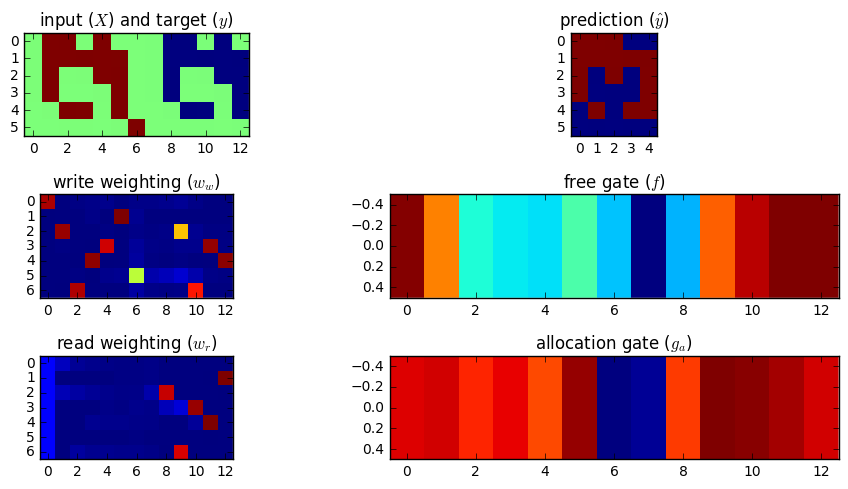

In [14]:
X, y = next_batch(FLAGS.batch_size, FLAGS.length, FLAGS.xlen)
tsteps = 2*FLAGS.length+3

feed = {dnc.X: X, dnc.y: y, dnc.tsteps: tsteps}
fetch = [outputs['y_hat'], outputs['w_w'], outputs['w_r'], outputs['f'], outputs['g_a']]
[_y_hat, _w_w, _w_r, _f, _g_a] = sess.run(fetch, feed)
_y_hat = np.clip(_y_hat, 1e-6, 1-1e-6)
_y = y[0] ; _X = X[0]

fig, ((ax1,ax2),(ax3,ax5),(ax4,ax6),) = plt.subplots(nrows=3, ncols=2)
plt.rcParams['savefig.facecolor'] = "0.8"
fs = 12 # font size
fig.set_figwidth(10)
fig.set_figheight(5)

ax1.imshow(_X.T - _y.T, interpolation='none') ; ax1.set_title('input ($X$) and target ($y$)')
ax2.imshow(_y_hat[0,-FLAGS.length:,:].T, interpolation='none') ; ax2.set_title('prediction ($\hat y$)')

ax3.imshow(_w_w[0,:,:].T, interpolation='none') ; ax3.set_title('write weighting ($w_w$)')
ax4.imshow(_w_r[0,:,:,0].T, interpolation='none') ; ax4.set_title('read weighting ($w_r$)')

ax5.imshow(_f[0,:,:].T, interpolation='none') ; ax5.set_title('free gate ($f$)') ; ax5.set_aspect(3)
ax6.imshow(_g_a[0,:,:].T, interpolation='none') ; ax6.set_title('allocation gate ($g_a$)') ; ax6.set_aspect(3)

plt.tight_layout()

In [12]:
# X, y = next_batch(FLAGS.batch_size, FLAGS.length, FLAGS.xlen)
# y = np.stack(y)
# y = y[:,FLAGS.length + 3:,:]
# y_shuffle = y[:,np.random.permutation(FLAGS.length),:]
# y_shuffle[:,-1,-1] = 4

# plt.figure(0, figsize=[2,2])
# plt.imshow(y[0,:,:].T, interpolation='none')
# plt.figure(1, figsize=[2,2])
# plt.imshow(y_shuffle[0,:,:].T, interpolation='none')
# plt.show()

# def np_loss(real_y, pred_y, FLAGS):
#     # sorry this is uuuuugly but we have to because it's batched
#     real_y = np.tile(real_y, [1,1,1,1]) ; real_y = np.transpose(real_y, (1,0,2,3))
#     pred_y = np.tile(pred_y,[1,1,1,1]) ; pred_y = np.transpose(pred_y, (1,0,2,3))
    
#     pred_y = np.tile(pred_y,[1,FLAGS.xlen-1,1,1])
#     pred_y = np.transpose(pred_y, (0,2,1,3))
    
#     real_y = real_y[0,:,:,:] ; pred_y = pred_y[0,:,:,:]
#     y_minus = .5*(real_y - pred_y)**2
#     y_minus = np.sum(y_minus, axis=-1)
#     y_minus = np.min(y_minus, axis=1)
    
#     return np.sum(y_minus) / (FLAGS.batch_size*FLAGS.length)

# X, real_y = next_batch(FLAGS.batch_size, FLAGS.length, FLAGS.xlen)
# real_y = np.stack(real_y)[:,-FLAGS.length:,:]

# pred_y = [y_i[np.random.permutation(y_i.shape[0]),:] for y_i in real_y]
# pred_y = np.stack(pred_y)
# # pred_y[:,-2:,-1] = 4

# np_loss(real_y, pred_y, FLAGS)